# Install and imports

In [1]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 29.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.0 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import datasets, layers, models
import inspect
import statistics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from keras_tuner import HyperModel, RandomSearch
import keras_tuner as kt

## Random seed

In [4]:
import tensorflow as tf
import numpy as np
import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Download and pre-process images

In [5]:
# Access the data file from google drive.
# Please ignore this code block if you have your files locally.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Path of the image
image_path = "drive/MyDrive/IMGS-TESIS-NUEVAS/Imagenes catalogadas"
image_list = os.listdir(image_path)
print("Number of images:", len(image_list))

Number of images: 47


In [7]:
images = []
labels = []


for image_name in image_list:
    path = os.path.join(image_path, image_name)
    image = Image.open(path,)
    image = image.resize((250, 250))

    # Convert to GrayScale
    if image.mode != 'L':
        image = image.convert('L')


    image_array = np.array(image)
    images.append(image_array)


    if image_name.startswith("PVA_MCC_0"):
        labels.append(33.18)
    elif image_name.startswith("PVA_MCC_1"):
        labels.append(18.87)
    elif image_name.startswith("PVA_MCC_3"):
        labels.append(18.74)
    elif image_name.startswith("PVA_MCC_5"):
        labels.append(14.23)


images = np.array(images)
labels = np.array(labels)


images = images.reshape(-1, 250, 250, 1)

# Data Augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode="wrap"
)


datagen.fit(images)


augmented_images = []
augmented_labels = []


for i in range(50):
    it = datagen.flow(images, labels, shuffle=False)
    batch_images, batch_labels = next(it)

    augmented_images.append(batch_images)
    augmented_labels.append(batch_labels)


augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


final_images = np.concatenate((images, augmented_images))
final_labels = np.concatenate((labels, augmented_labels))

print("Final dataset size:", len(final_images))

Final dataset size: 1647


Text(0.5, 1.0, 'Tensile strength18.87')

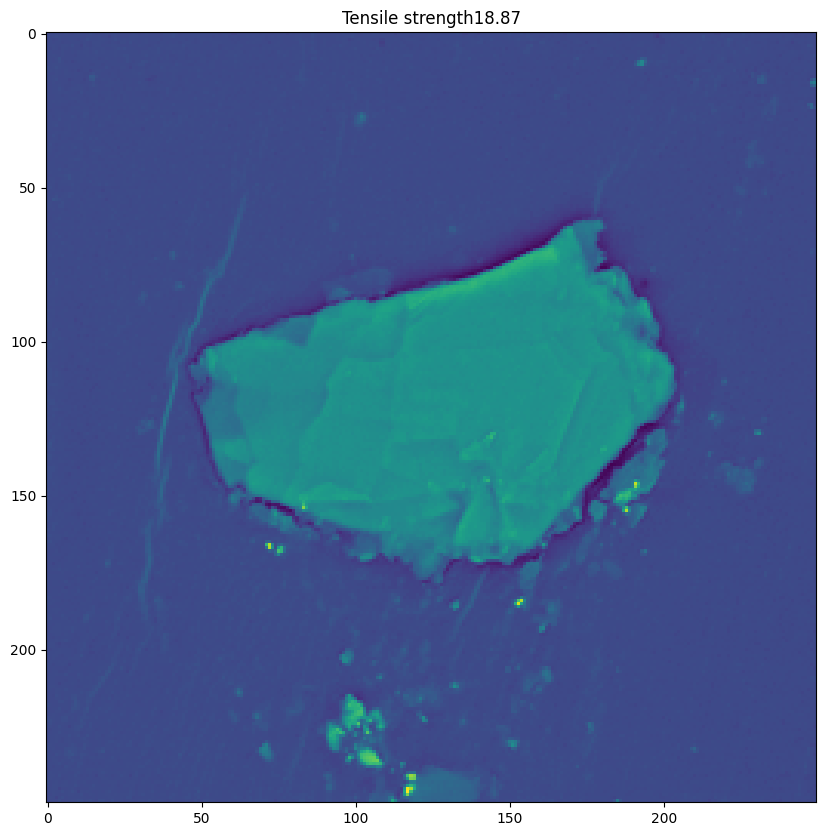

In [8]:
#Plot the images
plt.figure(figsize=(10,10))
plt.imshow(images[42])
plt.title("Tensile strength"+str(labels[42]))

In [9]:
train_images, test_images, train_labels, test_labels = train_test_split(final_images, final_labels, test_size=0.15, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

In [10]:
train_images = tf.convert_to_tensor(train_images/255, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)

test_images = tf.convert_to_tensor((test_images)/255, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

val_images = tf.convert_to_tensor(val_images/255, dtype=tf.float32)
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.float32)

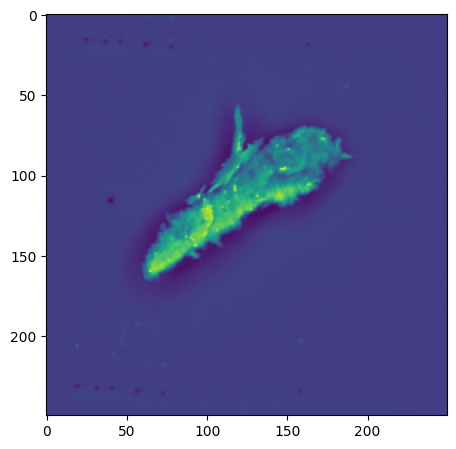

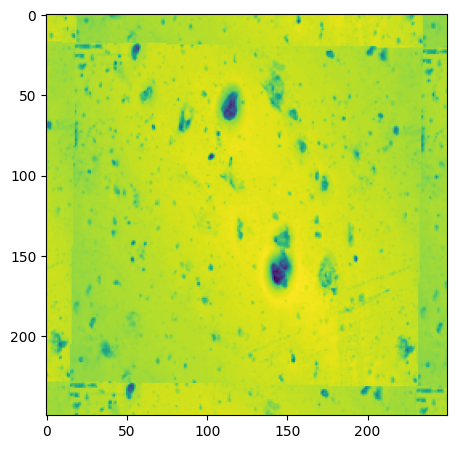

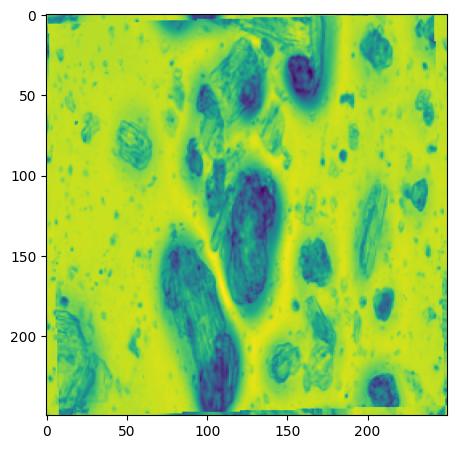

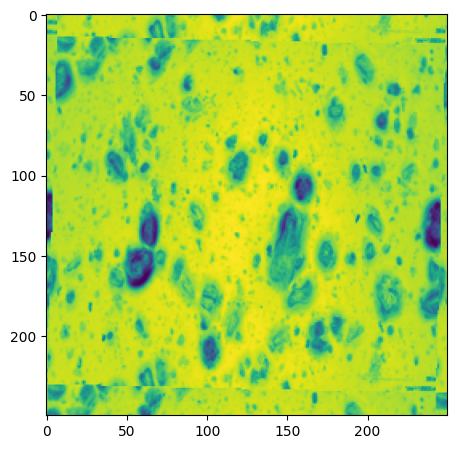

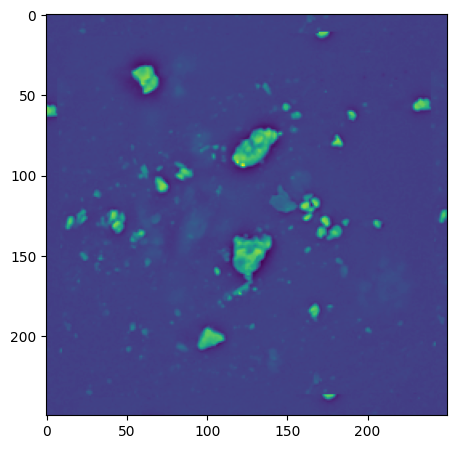

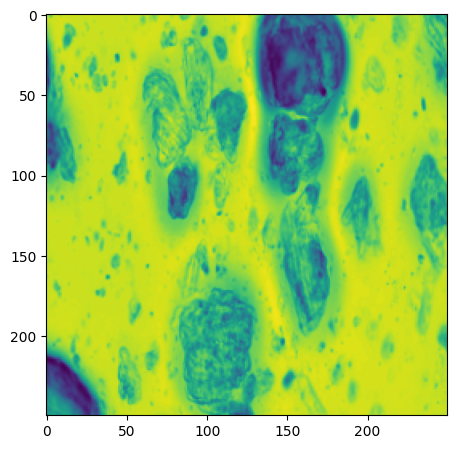

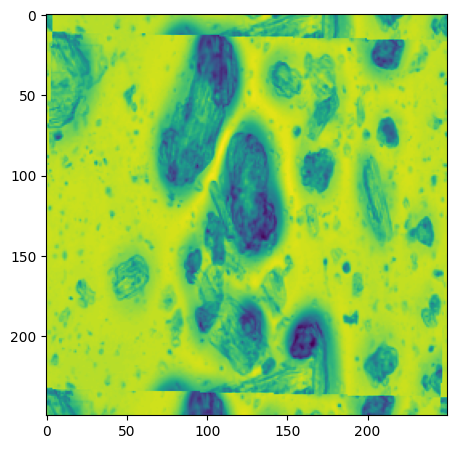

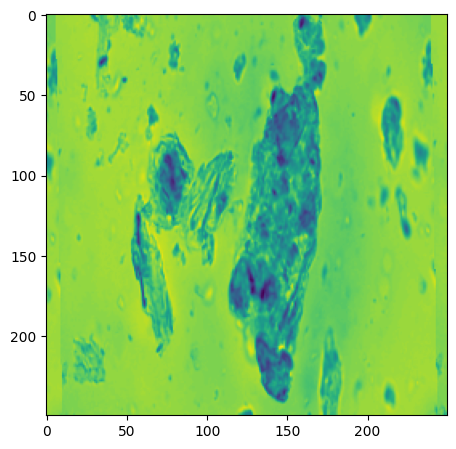

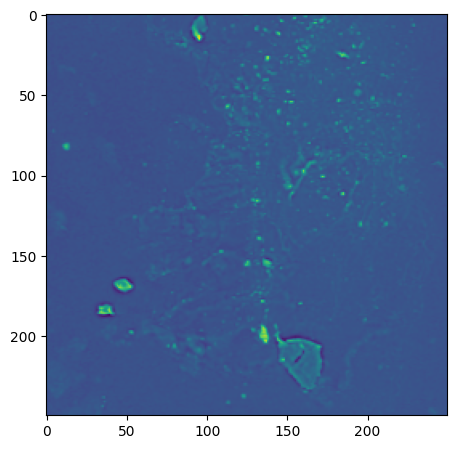

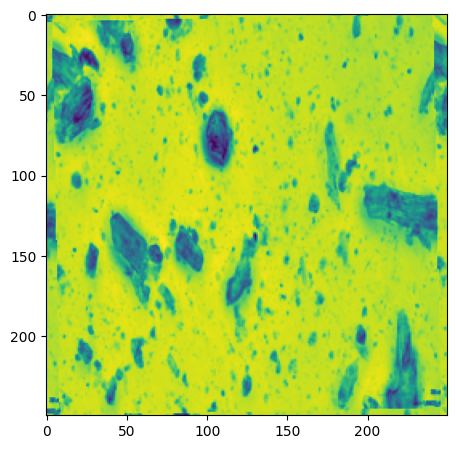

In [11]:
#Plot the generated images
for i in range(10):
  plt.figure(figsize=(30,30))
  plt.subplot(2,5,i+1)
  plt.imshow(train_images[i])


# HyperParameter optimization

## Functions

In [12]:
# Function to convert grayscale to RGB (3 channels). Inception V3 is pre-trained for RGB images
def preprocess_grayscale_to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

# Define the custom accuracy metric
def custom_accuracy(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred) / K.maximum(K.abs(y_true), K.epsilon()), axis=-1)

## Hyperparameter model

In [14]:
# Input shape for grayscale images
input_shape = (250, 250, 1)

def hp_model(hp):
    batch_size = hp.Int('batch_size', min_value=8, max_value=32, step=6)
    base_model = InceptionV3(input_shape=(250, 250, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Lambda(preprocess_grayscale_to_rgb))
    model.add(base_model)

    # Add custom layers
    model.add(layers.GlobalAveragePooling2D())

    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    dense_units = hp.Int('dense_units', min_value=64, max_value=512, step=64)
    model.add(layers.Dense(dense_units, activation='relu'))

    model.add(layers.Dense(1))

    # Model compile
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss="mse", metrics=[custom_accuracy])
    return model

## Tuning and search for optimal hyperparameters

In [15]:
tuner = RandomSearch(
    hp_model,
    objective=kt.Objective('val_loss', direction='min'),
    max_trials=15,
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='inceptionv3_transfer_learning'
)


lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


tuner.search(train_images, train_labels,
             validation_data=(test_images, test_labels),
             epochs=40,
             callbacks=[lr_reduce, early_stopping])


model = tuner.get_best_models(num_models=1)[0]


test_loss, test_custom_acc = model.evaluate(test_images, test_labels)
print(f"Found model test loss: {test_loss}, Test Accuracy: {test_custom_acc}")

Trial 15 Complete [00h 02m 17s]
val_loss: 1.0728017091751099

Best val_loss So Far: 0.8592181503772736
Total elapsed time: 00h 44m 38s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - custom_accuracy: 0.3095 - loss: 0.8374
Found model test loss: 0.812935471534729, Test Accuracy: 0.31485721468925476


In [16]:
# Store the optimal hyperparameters in a dictionay
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_hyperparams_dict = {
    'batch_size': best_hps.get('batch_size'),
    'learning_rate': best_hps.get('learning_rate'),
    'dense_units': best_hps.get('dense_units'),
    'dropout_rate': best_hps.get('dropout_rate')
}

print(best_hyperparams_dict)

{'batch_size': 14, 'learning_rate': 0.0006882586554868882, 'dense_units': 192, 'dropout_rate': 0.30000000000000004}


# Model evaluation

## Build and run the "best" model 20 times to evaluate performance

Run # 1
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 276ms/step - custom_accuracy: 0.3572 - loss: 0.2955 - val_custom_accuracy: 0.3311 - val_loss: 0.0806 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2842 - loss: 0.0891 - val_custom_accuracy: 0.3275 - val_loss: 0.0589 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2817 - loss: 0.0758 - val_custom_accuracy: 0.3089 - val_loss: 0.0653 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2822 - loss: 0.0741 - val_custom_accuracy: 0.3452 - val_loss: 0.0638 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_accuracy: 0.2814 - loss: 0.0692
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003441293374635279.
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2815 - loss: 0.0692 - val_custom_accuracy: 0.3066 - val_loss: 0.0703 - le

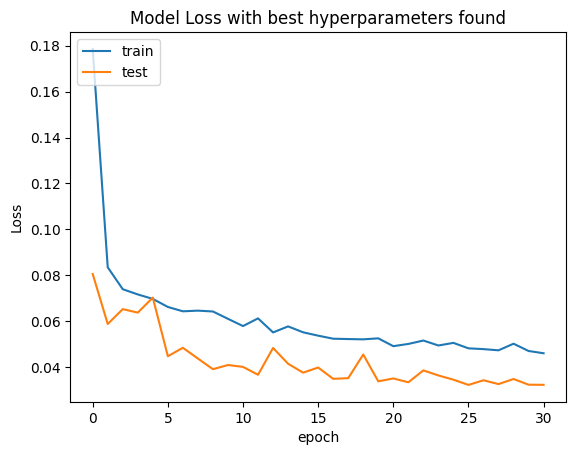

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Hits within 5% error: 0.75
Hits within 10% error: 0.9838709677419355
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - custom_accuracy: 0.3134 - loss: 0.0322
Run # 2
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - custom_accuracy: 0.3657 - loss: 0.2984 - val_custom_accuracy: 0.3164 - val_loss: 0.0770 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2786 - loss: 0.0907 - val_custom_accuracy: 0.3226 - val_loss: 0.0691 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2818 - loss: 0.0774 - val_custom_accuracy: 0.3354 - val_loss: 0.0640 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2738 - loss: 0.0714 - val_custom_accuracy: 0.3124 - val_loss: 0.0738 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2793 - loss: 0.0708 - val_custom_accuracy: 0.310

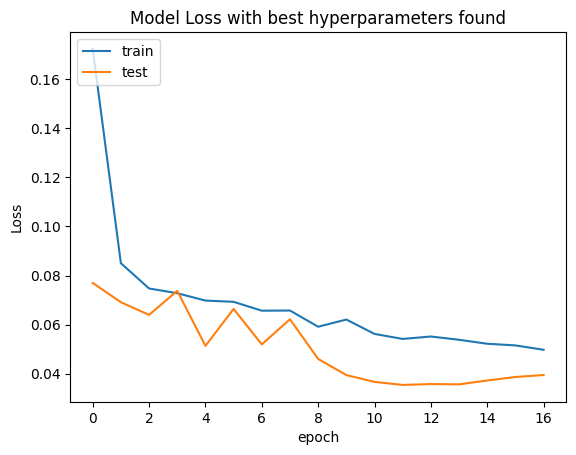

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.7580645161290323
Hits within 10% error: 0.967741935483871
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3188 - loss: 0.0376
Run # 3
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - custom_accuracy: 0.3559 - loss: 0.2960 - val_custom_accuracy: 0.3228 - val_loss: 0.0777 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2835 - loss: 0.0852 - val_custom_accuracy: 0.3228 - val_loss: 0.0907 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2824 - loss: 0.0810 - val_custom_accuracy: 0.3305 - val_loss: 0.0780 - learning_rate: 6.8826e-04
Epoch 4/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_accuracy: 0.2796 - loss: 0.0733
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003441293374635279.
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2798 - loss: 0.0733 - val_custom_accuracy: 0.313

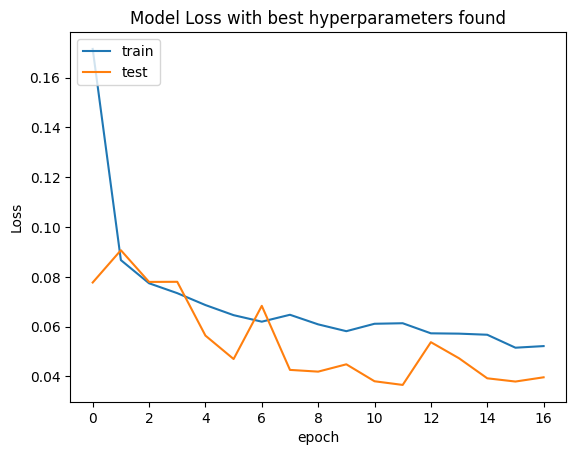

1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.6854838709677419
Hits within 10% error: 0.967741935483871
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3100 - loss: 0.0395
Run # 4
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - custom_accuracy: 0.3683 - loss: 0.3027 - val_custom_accuracy: 0.3336 - val_loss: 0.0794 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2878 - loss: 0.0953 - val_custom_accuracy: 0.3322 - val_loss: 0.0662 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2834 - loss: 0.0762 - val_custom_accuracy: 0.3457 - val_loss: 0.0679 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2817 - loss: 0.0747 - val_custom_accuracy: 0.3220 - val_loss: 0.0688 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2822 - loss: 0.0733 - val_custom_acc

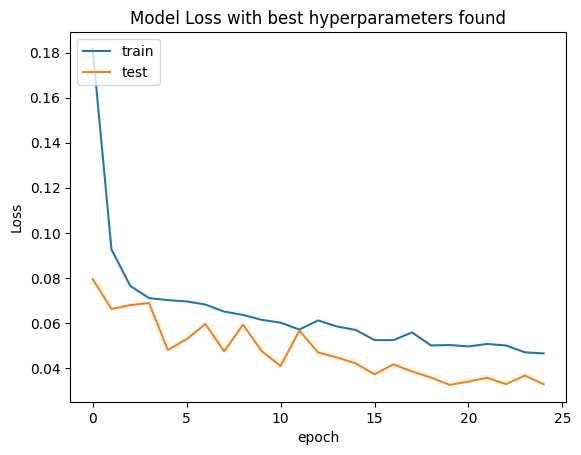

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.717741935483871
Hits within 10% error: 0.967741935483871
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3147 - loss: 0.0335
Run # 5
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - custom_accuracy: 0.3665 - loss: 0.3033 - val_custom_accuracy: 0.3303 - val_loss: 0.0891 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2831 - loss: 0.0875 - val_custom_accuracy: 0.3129 - val_loss: 0.0642 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2797 - loss: 0.0743 - val_custom_accuracy: 0.3098 - val_loss: 0.0630 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2808 - loss: 0.0770 - val_custom_accuracy: 0.3418 - val_loss: 0.0613 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2808 - loss: 0.0714 - val_custom_accu

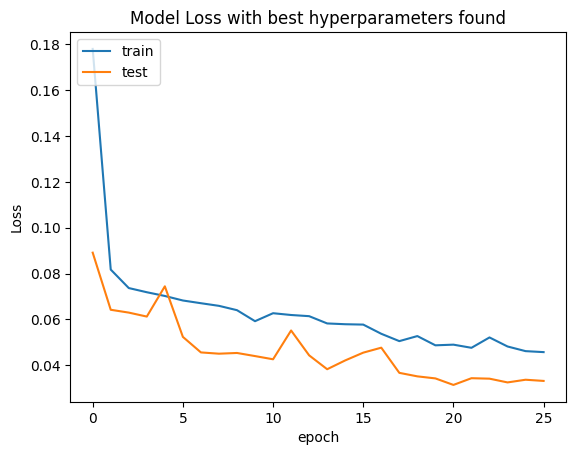

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.7419354838709677
Hits within 10% error: 0.9758064516129032
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3161 - loss: 0.0323
Run # 6
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - custom_accuracy: 0.3579 - loss: 0.2904 - val_custom_accuracy: 0.3177 - val_loss: 0.0731 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2812 - loss: 0.0889 - val_custom_accuracy: 0.3211 - val_loss: 0.0682 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2780 - loss: 0.0775 - val_custom_accuracy: 0.3310 - val_loss: 0.0611 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2811 - loss: 0.0751 - val_custom_accuracy: 0.3393 - val_loss: 0.0647 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2808 - loss: 0.0686 - val_custom_ac

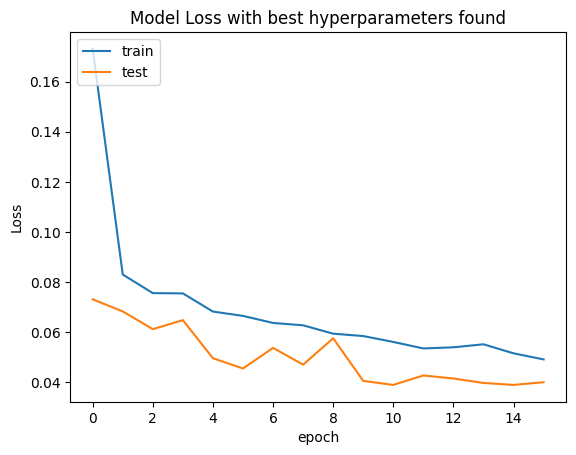

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.75
Hits within 10% error: 0.9516129032258065
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3173 - loss: 0.0355
Run # 7
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - custom_accuracy: 0.3668 - loss: 0.2986 - val_custom_accuracy: 0.3412 - val_loss: 0.0925 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2823 - loss: 0.0888 - val_custom_accuracy: 0.3382 - val_loss: 0.0743 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2885 - loss: 0.0844 - val_custom_accuracy: 0.3167 - val_loss: 0.0554 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2795 - loss: 0.0799 - val_custom_accuracy: 0.3173 - val_loss: 0.0603 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2782 - loss: 0.0682 - val_custom_accuracy: 0.3398

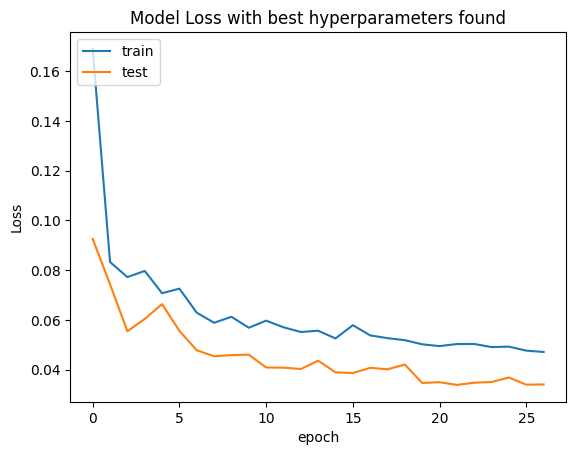

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Hits within 5% error: 0.7096774193548387
Hits within 10% error: 0.9758064516129032
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3126 - loss: 0.0357
Run # 8
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - custom_accuracy: 0.3668 - loss: 0.2959 - val_custom_accuracy: 0.3236 - val_loss: 0.0707 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2836 - loss: 0.0866 - val_custom_accuracy: 0.3084 - val_loss: 0.0759 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2772 - loss: 0.0771 - val_custom_accuracy: 0.3117 - val_loss: 0.0748 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2779 - loss: 0.0735 - val_custom_accuracy: 0.3195 - val_loss: 0.0648 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2772 - loss: 0.0705 - val_custom_ac

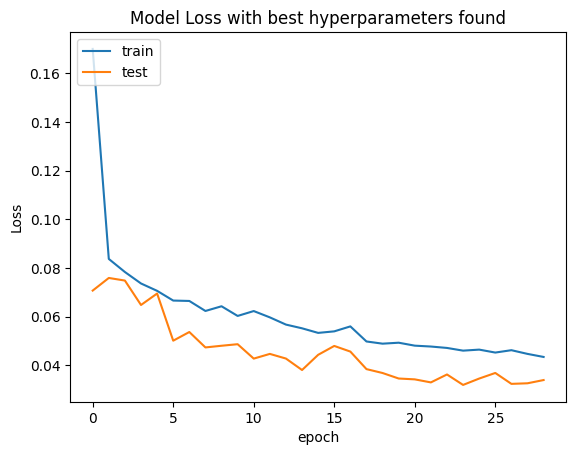

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.75
Hits within 10% error: 0.967741935483871
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3227 - loss: 0.0348
Run # 9
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - custom_accuracy: 0.3613 - loss: 0.2918 - val_custom_accuracy: 0.3298 - val_loss: 0.0799 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2852 - loss: 0.0867 - val_custom_accuracy: 0.3237 - val_loss: 0.0679 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2792 - loss: 0.0781 - val_custom_accuracy: 0.3249 - val_loss: 0.0629 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2815 - loss: 0.0736 - val_custom_accuracy: 0.3083 - val_loss: 0.0610 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2812 - loss: 0.0706 - val_custom_accuracy: 0.3255 

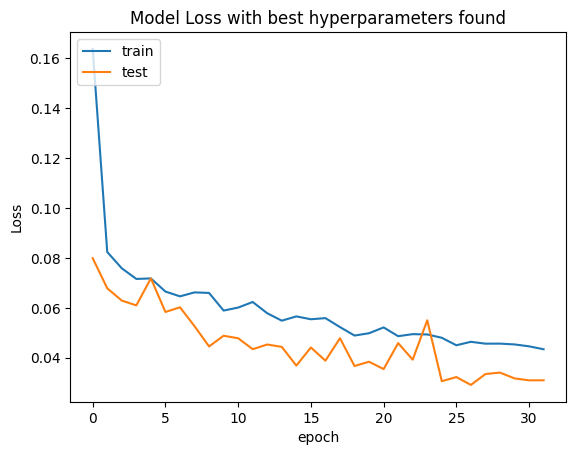

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.782258064516129
Hits within 10% error: 0.9758064516129032
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3107 - loss: 0.0338
Run # 10
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - custom_accuracy: 0.3718 - loss: 0.3039 - val_custom_accuracy: 0.3120 - val_loss: 0.0774 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2852 - loss: 0.0921 - val_custom_accuracy: 0.3498 - val_loss: 0.0839 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2859 - loss: 0.0829 - val_custom_accuracy: 0.3175 - val_loss: 0.0597 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2798 - loss: 0.0712 - val_custom_accuracy: 0.3209 - val_loss: 0.0589 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2778 - loss: 0.0689 - val_custom_ac

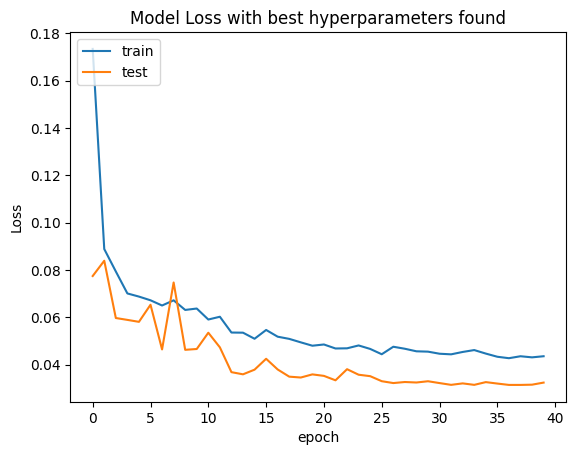

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.8064516129032258
Hits within 10% error: 0.9838709677419355
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3155 - loss: 0.0312
Run # 11
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - custom_accuracy: 0.3737 - loss: 0.3036 - val_custom_accuracy: 0.3208 - val_loss: 0.0739 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2825 - loss: 0.0914 - val_custom_accuracy: 0.3203 - val_loss: 0.0678 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2822 - loss: 0.0807 - val_custom_accuracy: 0.3308 - val_loss: 0.0715 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2869 - loss: 0.0779 - val_custom_accuracy: 0.3075 - val_loss: 0.0649 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2791 - loss: 0.0690 - val_custom_a

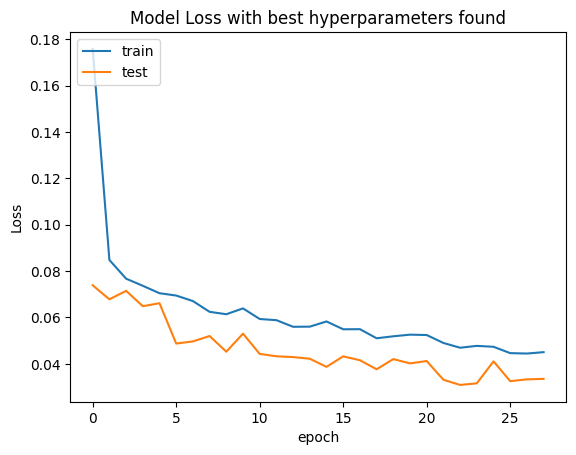

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step
Hits within 5% error: 0.7903225806451613
Hits within 10% error: 0.9758064516129032
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3157 - loss: 0.0307
Run # 12
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - custom_accuracy: 0.3728 - loss: 0.2988 - val_custom_accuracy: 0.3423 - val_loss: 0.0848 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2875 - loss: 0.0962 - val_custom_accuracy: 0.3148 - val_loss: 0.0673 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2838 - loss: 0.0830 - val_custom_accuracy: 0.3278 - val_loss: 0.0558 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2800 - loss: 0.0722 - val_custom_accuracy: 0.3187 - val_loss: 0.0703 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2828 - loss: 0.0713 - val_custom_a

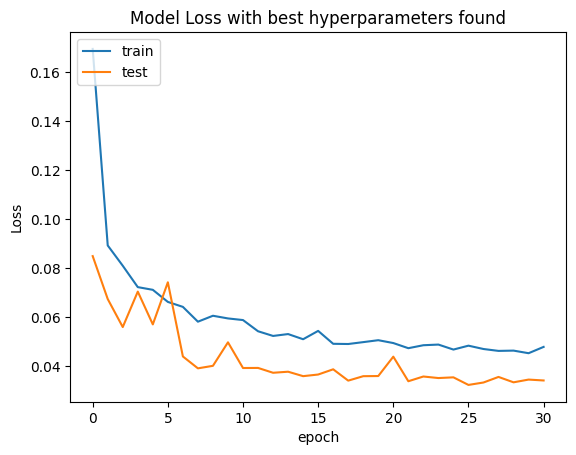

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Hits within 5% error: 0.75
Hits within 10% error: 0.9838709677419355
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3188 - loss: 0.0337
Run # 13
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - custom_accuracy: 0.3643 - loss: 0.3085 - val_custom_accuracy: 0.3158 - val_loss: 0.0729 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2806 - loss: 0.0892 - val_custom_accuracy: 0.3181 - val_loss: 0.0736 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2790 - loss: 0.0765 - val_custom_accuracy: 0.3126 - val_loss: 0.0600 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2771 - loss: 0.0714 - val_custom_accuracy: 0.3161 - val_loss: 0.0590 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2791 - loss: 0.0726 - val_custom_accuracy: 0.316

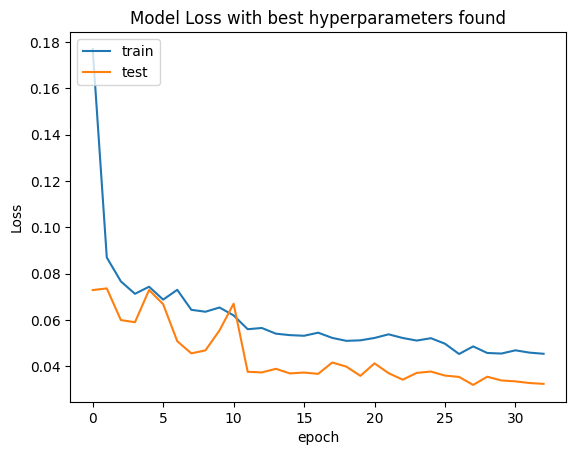

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.782258064516129
Hits within 10% error: 0.9838709677419355
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3133 - loss: 0.0332
Run # 14
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - custom_accuracy: 0.3619 - loss: 0.2997 - val_custom_accuracy: 0.3147 - val_loss: 0.0736 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2803 - loss: 0.0883 - val_custom_accuracy: 0.3110 - val_loss: 0.0657 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2787 - loss: 0.0780 - val_custom_accuracy: 0.3084 - val_loss: 0.0638 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2758 - loss: 0.0708 - val_custom_accuracy: 0.3373 - val_loss: 0.0562 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2799 - loss: 0.0704 - val_custom_ac

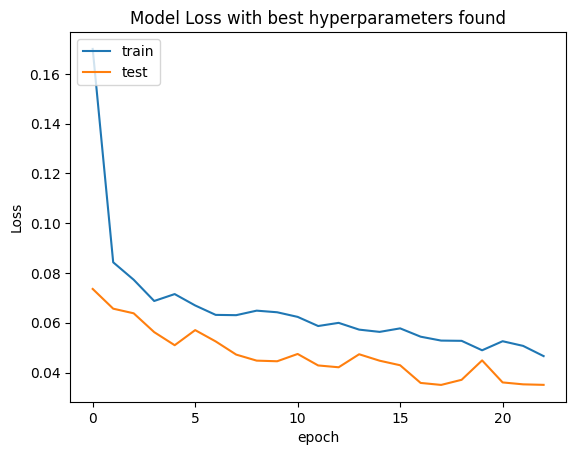

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.7016129032258065
Hits within 10% error: 0.9516129032258065
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3179 - loss: 0.0387
Run # 15
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - custom_accuracy: 0.3643 - loss: 0.3031 - val_custom_accuracy: 0.3226 - val_loss: 0.0745 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2855 - loss: 0.0837 - val_custom_accuracy: 0.3110 - val_loss: 0.0683 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2797 - loss: 0.0781 - val_custom_accuracy: 0.3376 - val_loss: 0.0617 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2827 - loss: 0.0764 - val_custom_accuracy: 0.3203 - val_loss: 0.0527 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2803 - loss: 0.0698 - val_custom_a

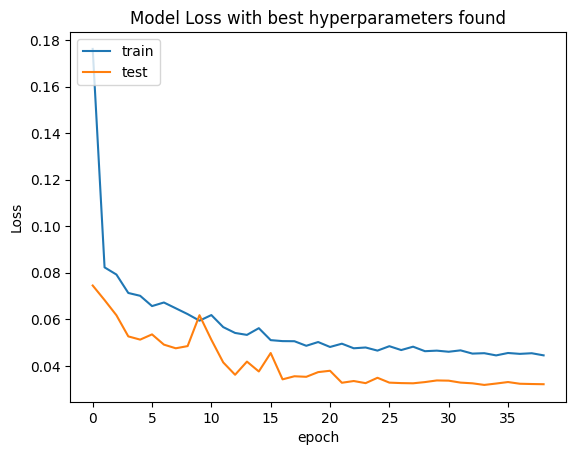

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Hits within 5% error: 0.7580645161290323
Hits within 10% error: 0.9758064516129032
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3147 - loss: 0.0324
Run # 16
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step - custom_accuracy: 0.3730 - loss: 0.3099 - val_custom_accuracy: 0.3322 - val_loss: 0.0773 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2847 - loss: 0.0892 - val_custom_accuracy: 0.3310 - val_loss: 0.0640 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2827 - loss: 0.0770 - val_custom_accuracy: 0.3257 - val_loss: 0.0692 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2859 - loss: 0.0812 - val_custom_accuracy: 0.3206 - val_loss: 0.0521 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2802 - loss: 0.0718 - val_custom_a

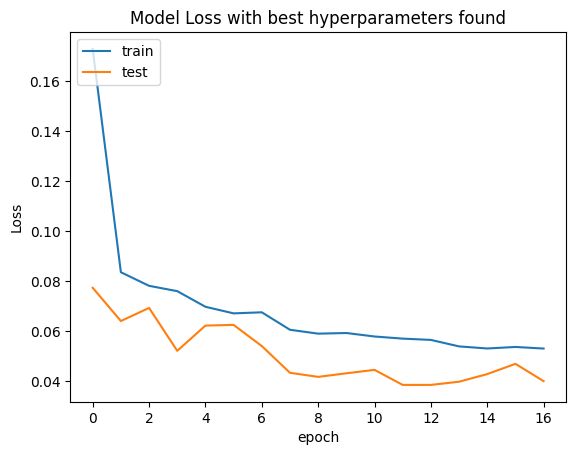

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Hits within 5% error: 0.6774193548387096
Hits within 10% error: 0.9596774193548387
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3152 - loss: 0.0393
Run # 17
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - custom_accuracy: 0.3663 - loss: 0.2935 - val_custom_accuracy: 0.3231 - val_loss: 0.0803 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2790 - loss: 0.0842 - val_custom_accuracy: 0.3306 - val_loss: 0.0676 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - custom_accuracy: 0.2853 - loss: 0.0804 - val_custom_accuracy: 0.3290 - val_loss: 0.0582 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2812 - loss: 0.0729 - val_custom_accuracy: 0.3218 - val_loss: 0.0602 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2763 - loss: 0.0704 - val_custom_a

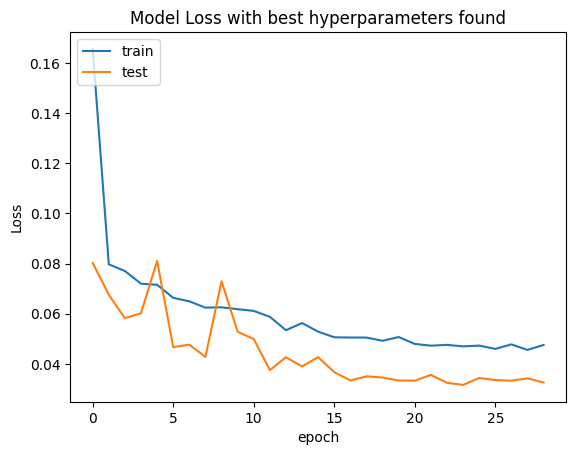

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Hits within 5% error: 0.7580645161290323
Hits within 10% error: 0.9596774193548387
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3123 - loss: 0.0338
Run # 18
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 178ms/step - custom_accuracy: 0.3556 - loss: 0.2881 - val_custom_accuracy: 0.3190 - val_loss: 0.0802 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2809 - loss: 0.0842 - val_custom_accuracy: 0.3245 - val_loss: 0.0683 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2829 - loss: 0.0797 - val_custom_accuracy: 0.3208 - val_loss: 0.0591 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2791 - loss: 0.0732 - val_custom_accuracy: 0.3244 - val_loss: 0.0622 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2793 - loss: 0.0709 - val_custom_a

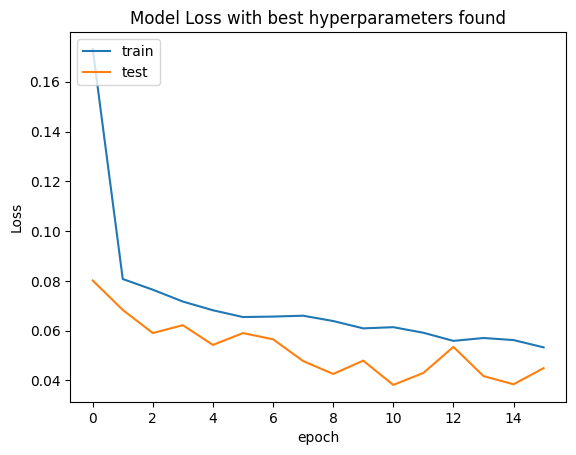

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Hits within 5% error: 0.6774193548387096
Hits within 10% error: 0.9435483870967742
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3259 - loss: 0.0393
Run # 19
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - custom_accuracy: 0.3649 - loss: 0.3035 - val_custom_accuracy: 0.3360 - val_loss: 0.0871 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2839 - loss: 0.0857 - val_custom_accuracy: 0.3296 - val_loss: 0.0725 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2830 - loss: 0.0779 - val_custom_accuracy: 0.3155 - val_loss: 0.0558 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2810 - loss: 0.0731 - val_custom_accuracy: 0.3046 - val_loss: 0.0541 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2805 - loss: 0.0716 - val_custom_a

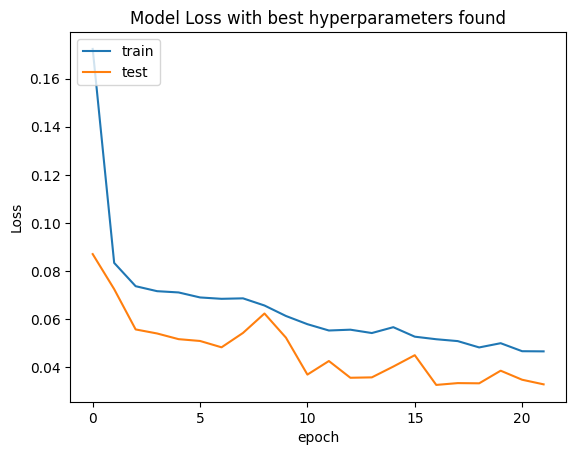

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Hits within 5% error: 0.7580645161290323
Hits within 10% error: 0.967741935483871
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3141 - loss: 0.0357
Run # 20
Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 177ms/step - custom_accuracy: 0.3723 - loss: 0.2972 - val_custom_accuracy: 0.3236 - val_loss: 0.0860 - learning_rate: 6.8826e-04
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_accuracy: 0.2843 - loss: 0.0894 - val_custom_accuracy: 0.3307 - val_loss: 0.0600 - learning_rate: 6.8826e-04
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - custom_accuracy: 0.2820 - loss: 0.0772 - val_custom_accuracy: 0.3173 - val_loss: 0.0676 - learning_rate: 6.8826e-04
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - custom_accuracy: 0.2809 - loss: 0.0740 - val_custom_accuracy: 0.3190 - val_loss: 0.0633 - learning_rate: 6.8826e-04
Epoch 5/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - custom_accuracy: 0.2774 - loss: 0.0729 - val_custom_ac

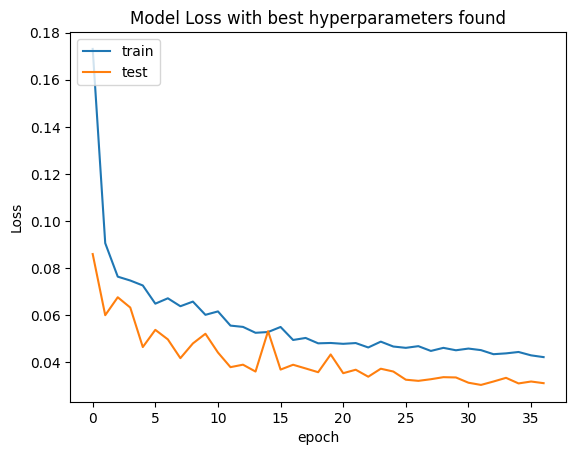

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Hits within 5% error: 0.7580645161290323
Hits within 10% error: 0.9838709677419355
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - custom_accuracy: 0.3159 - loss: 0.0298


In [17]:
# Initialize lists to store results
l_hits5 = []
l_hits10 = []
l_loss = []

# Run the model 20 times for statistics
for i in range(20):
  print("Run #", 1+i)
  # Build the model with the tuned hyperparameters using Functional API
  def build_model_with_best_params():
      input_shape = (250, 250, 1)

      inputs = layers.Input(shape=input_shape)


      x = layers.Lambda(preprocess_grayscale_to_rgb)(inputs)


      base_model = InceptionV3(input_shape=(250, 250, 3), include_top=False, weights='imagenet')
      base_model.trainable = False


      x = base_model(x)


      x = layers.GlobalAveragePooling2D()(x)
      x = layers.Dropout(best_hyperparams_dict['dropout_rate'])(x)
      x = layers.Dense(best_hyperparams_dict['dense_units'], activation='relu')(x)


      outputs = layers.Dense(1)(x)


      model = models.Model(inputs=inputs, outputs=outputs)
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparams_dict['learning_rate']),
                    loss=custom_accuracy,
                    metrics=[custom_accuracy])

      return model

  lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  model = build_model_with_best_params()


  history = model.fit(train_images, train_labels,
                      epochs=40,
                      batch_size=best_hyperparams_dict['batch_size'],
                      validation_data=(test_images, test_labels),
                      callbacks=[lr_reduce, early_stopping])

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss with best hyperparameters found')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


  predictions_test = model.predict(val_images)

  count = 0
  for i in range(len(predictions_test)):
      error = float(abs(predictions_test[i] - val_labels[i]) * 100 / val_labels[i])
      if error <= 5.00:
          count += 1

  print(f"Hits within 5% error: {count/len(predictions_test)}")
  l_hits5.append(count/len(predictions_test))


  count = 0
  for i in range(len(predictions_test)):
      error = float(abs(predictions_test[i] - val_labels[i]) * 100 / val_labels[i])
      if error <= 10.00:
          count += 1

  print(f"Hits within 10% error: {count/len(predictions_test)}")
  l_hits10.append(count/len(predictions_test))

  loss = model.evaluate(val_images, val_labels)
  l_loss.append(loss[1])

## Statistics

In [18]:
mean5 = statistics.mean(l_hits5)
mean10 = statistics.mean(l_hits10)
mean_loss = statistics.mean(l_loss)


stdev5 = statistics.stdev(l_hits5)
stdev10 = statistics.stdev(l_hits10)
stdev_loss = statistics.stdev(l_loss)


print(f"Mean (5% margin): {mean5}")
print(f"Mean (10% margin): {mean10}")
print(f"Mean Loss: {mean_loss}\n")
print(f"Standard Deviation (5% margin): {stdev5}")
print(f"Standard Deviation (10% margin): {stdev10}")
print(f"Standard Deviation Loss: {stdev_loss}")


Mean (5% margin): 0.7431451612903226
Mean (10% margin): 0.9701612903225807
Mean Loss: 0.3159338414669037

Standard Deviation (5% margin): 0.03702796822700806
Standard Deviation (10% margin): 0.012018706780170871
Standard Deviation Loss: 0.003821539597733188


# Save the trained model

In [19]:
model.save('optimal_hyperparameters_transfer_learning_model.h5')

In [20]:
predictions = model.predict(images/255)

count = 0
for i in range(len(predictions)):
    error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])
    if error <= 5.00:
        count += 1

print(f"Hits within 5% error: {count/len(predictions)}")



count = 0
for i in range(len(predictions)):
    error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])
    if error <= 10.00:
        count += 1

print(f"Hits within 10% error: {count/len(predictions)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Hits within 5% error: 0.7659574468085106
Hits within 10% error: 0.9361702127659575


<ipython-input-20-a6efc4c3bbff>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])
<ipython-input-20-a6efc4c3bbff>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = float(abs(predictions[i] - labels[i]) * 100 / labels[i])


# Save hyperparameters tunings (optional)

In [23]:
!zip -r /content/drive/MyDrive/file.zip /content/hyperparam_tuning

  adding: content/hyperparam_tuning/ (stored 0%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/ (stored 0%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_07/ (stored 0%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_07/trial.json (deflated 67%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_07/build_config.json (deflated 11%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_07/checkpoint.weights.h5 (deflated 8%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_12/ (stored 0%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_12/trial.json (deflated 67%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_12/build_config.json (deflated 11%)
  adding: content/hyperparam_tuning/inceptionv3_transfer_learning/trial_12/checkpoint.weights.h5 (deflated 8%)
  adding: content/hyperparam_tuning/inceptionv3_transfer